decay
kernel.weight
torch.Size([64, 3, 7, 7])
kernel.bias
NormLayer.weight
NormLayer.bias


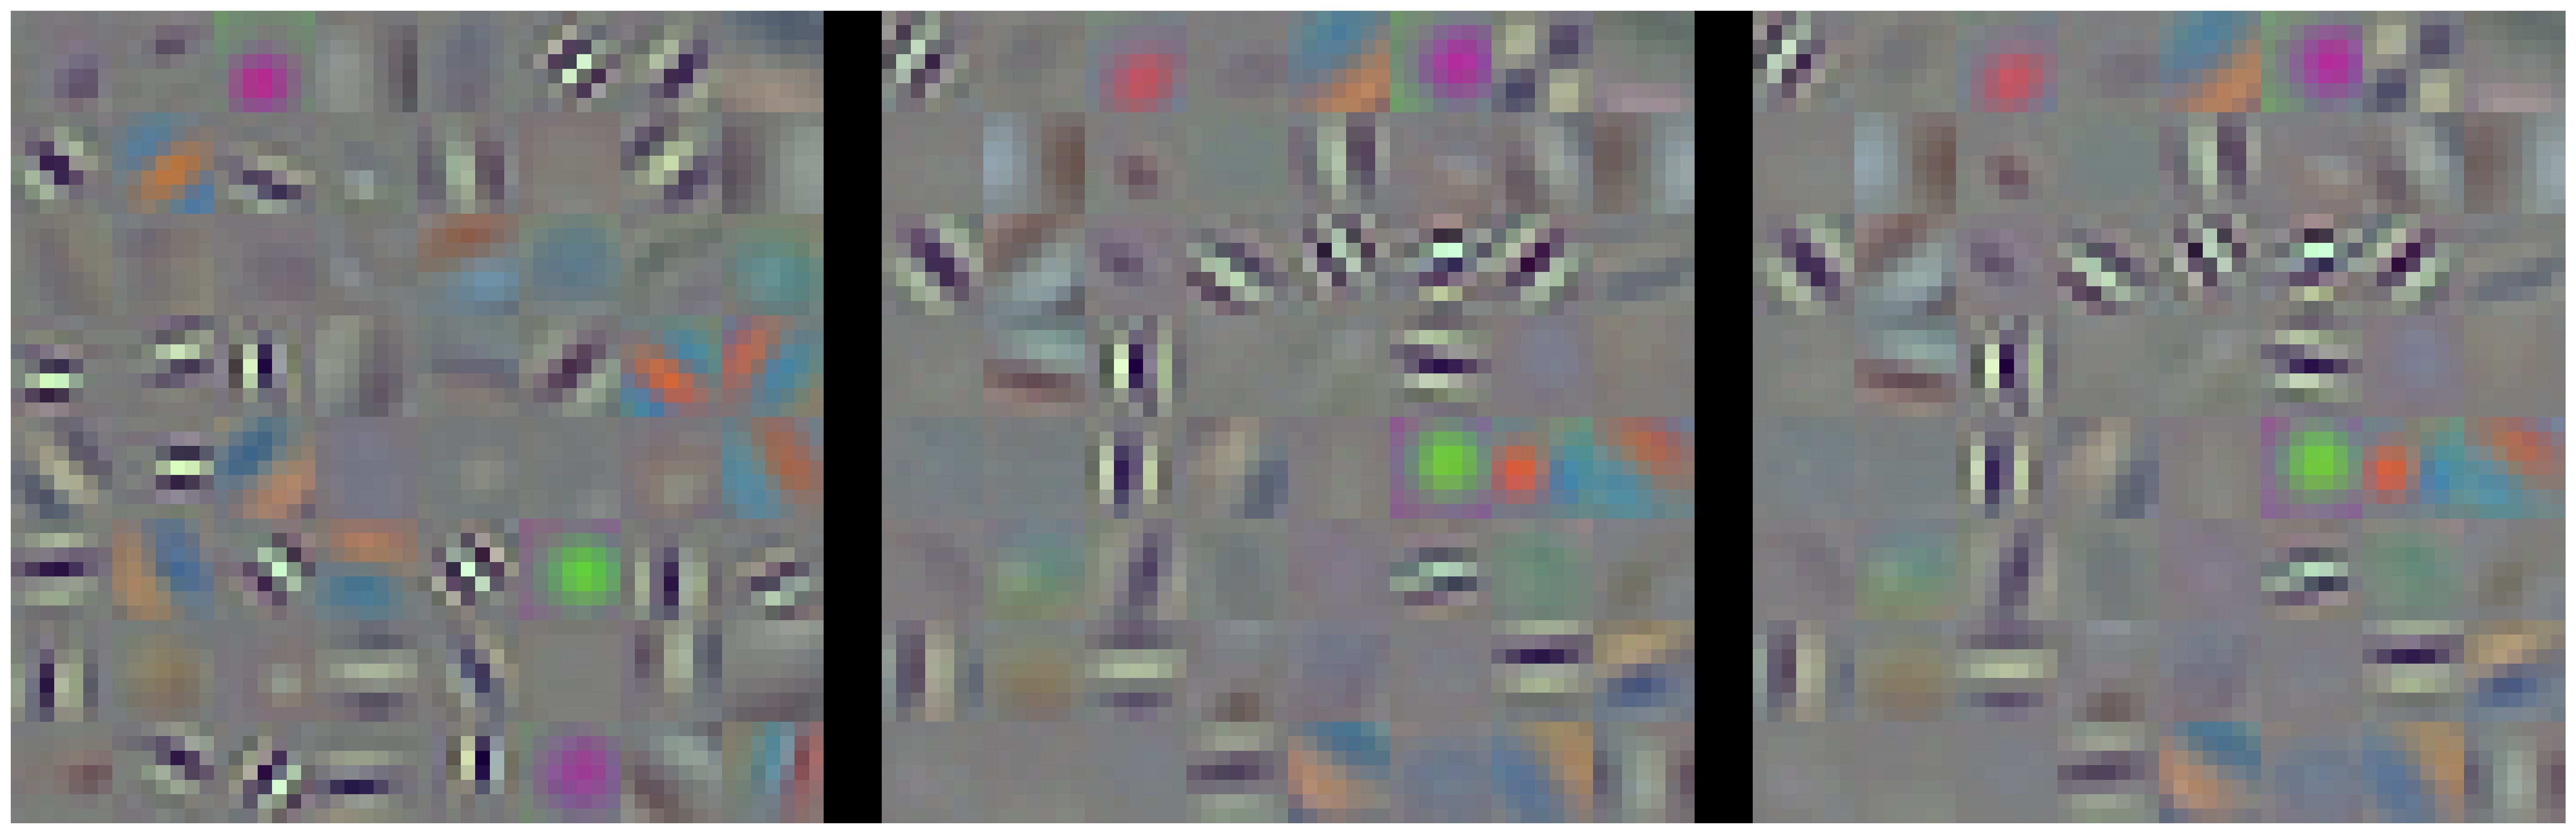

In [5]:
from __future__ import print_function
import sys
sys.path.append("..")
from util.util import lr_scheduler
from datasets.es_imagenet import ESImagenet_Dataset
import LIAF
from LIAFnet.LIAFResNet import *

import torchvision
import torchvision.transforms as transforms
import torch.distributed as dist 
import torch.nn as nn
import argparse, pickle, torch, time, os,sys
from importlib import import_module

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import matplotlib



##################### Step1. Env Preparation #####################
import os
save_folder = 'VizParam'
device = torch.device("cpu")

##################### Step2. load in dataset #####################

train_path = '/data/imagenet2012_png/train' 
test_path = '/data/imagenet2012_png/val' 

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 1
train_dataset = torchvision.datasets.ImageFolder(root= train_path, transform=transform_train)
test_dataset = torchvision.datasets.ImageFolder(root= test_path,transform=transform_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1,pin_memory=True)

##################### tep3. establish module #####################

checkpoint = torch.load('../exp_ES_imagenet/ResNet18_imagenet_CNN/65.pkl', map_location=torch.device('cpu'))
modules = import_module('LIAFnet.LIAFResNet_18')
CNN_config  = modules.Config()
CNN_config.cfgCnn = [3, 64, 7, True]
CNN = LIAFResNet(CNN_config)
CNN.load_state_dict(checkpoint)

checkpoint = torch.load('../exp_ES_imagenet/ResNet18_imagenet_LIAF/49.pkl', map_location=torch.device('cpu'))
LIF18_config  = modules.Config()
LIF18_config.cfgCnn = [3, 64, 7, True]
LIF18_config.actfun = LIAF.LIFactFun.apply
LIF18 = LIAFResNet(LIF18_config)
LIF18.load_state_dict(checkpoint)


checkpoint = torch.load('../exp_ES_imagenet/ResNet18_imagenet_LIAF/48.pkl', map_location=torch.device('cpu'))
LIAF18_config  = modules.Config()
LIAF18_config.cfgCnn = [3, 64, 7, True]
LIAF18 = LIAFResNet(LIF18_config)
LIAF18.load_state_dict(checkpoint)

    
CNNconv = CNN.conv1
LIFconv = LIF18.conv1    
LIAFconv = LIAF18.conv1

wieght_size = 0

for _,param in enumerate(CNNconv.named_parameters()):
    print(param[0])
    if param[0] == 'kernel.weight':
        wieght_size = param[1].size(3)
        print(param[1].size())

gap = 60
canve = torch.zeros(wieght_size*8,wieght_size*8+gap*2,3)

cnn_dict = {}
lif_dict = {}

for _,param in enumerate(CNNconv.named_parameters()):
    if param[0] == 'kernel.weight':
        a =  param[1]
        for i in range(64):
            canve[i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size,0] = param[1][i,0,:,:]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size,1] = param[1][i,1,:,:]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size,2] = param[1][i,2,:,:]
        
for _,param in enumerate(LIAFconv.named_parameters()):
    if param[0] == 'kernel.weight':
        b =  param[1]
        for i in range(64):
            canve[i//8*wieght_size:(i//8+1)*wieght_size,gap+i%8*wieght_size:gap+(i%8+1)*wieght_size,0] = param[1][i,0,:,:]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,gap+i%8*wieght_size:gap+(i%8+1)*wieght_size,1] = param[1][i,1,:,:]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,gap+i%8*wieght_size:gap+(i%8+1)*wieght_size,2] = param[1][i,2,:,:]
        
for _,param in enumerate(LIFconv.named_parameters()):
    if param[0] == 'kernel.weight':
        c =  param[1]
        for i in range(64):
            canve[i//8*wieght_size:(i//8+1)*wieght_size,2*gap+i%8*wieght_size:2*gap+(i%8+1)*wieght_size,0] = param[1][i,0,:,:]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,2*gap+i%8*wieght_size:2*gap+(i%8+1)*wieght_size,1] = param[1][i,1,:,:]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,2*gap+i%8*wieght_size:2*gap+(i%8+1)*wieght_size,2] = param[1][i,2,:,:]
        

def norm_canve(canve):
    return (canve - torch.min(canve))/(torch.max(canve)-torch.min(canve)) * 255

canve[:,0:wieght_size*8,:] =  norm_canve(canve[:,0:wieght_size*8,:])
canve[:,gap:gap+wieght_size*8,:] =  norm_canve(canve[:,gap:gap+wieght_size*8,:])
canve[:,gap*2:gap*2+wieght_size*8,:] =  norm_canve(canve[:,gap*2:gap*2+wieght_size*8,:])


task = 'Vizparam'

plt.rcParams['figure.figsize'] = (32.5,10) # 设置figure_size尺寸
plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率


plt.figure("test") # 图像窗口名称
plt.imshow(canve.int().numpy())
plt.axis('off') # 关掉坐标轴为 off
plt.savefig('Visresult/'+task+'_Imagenet.png', format='png')
plt.show()




weight
bias


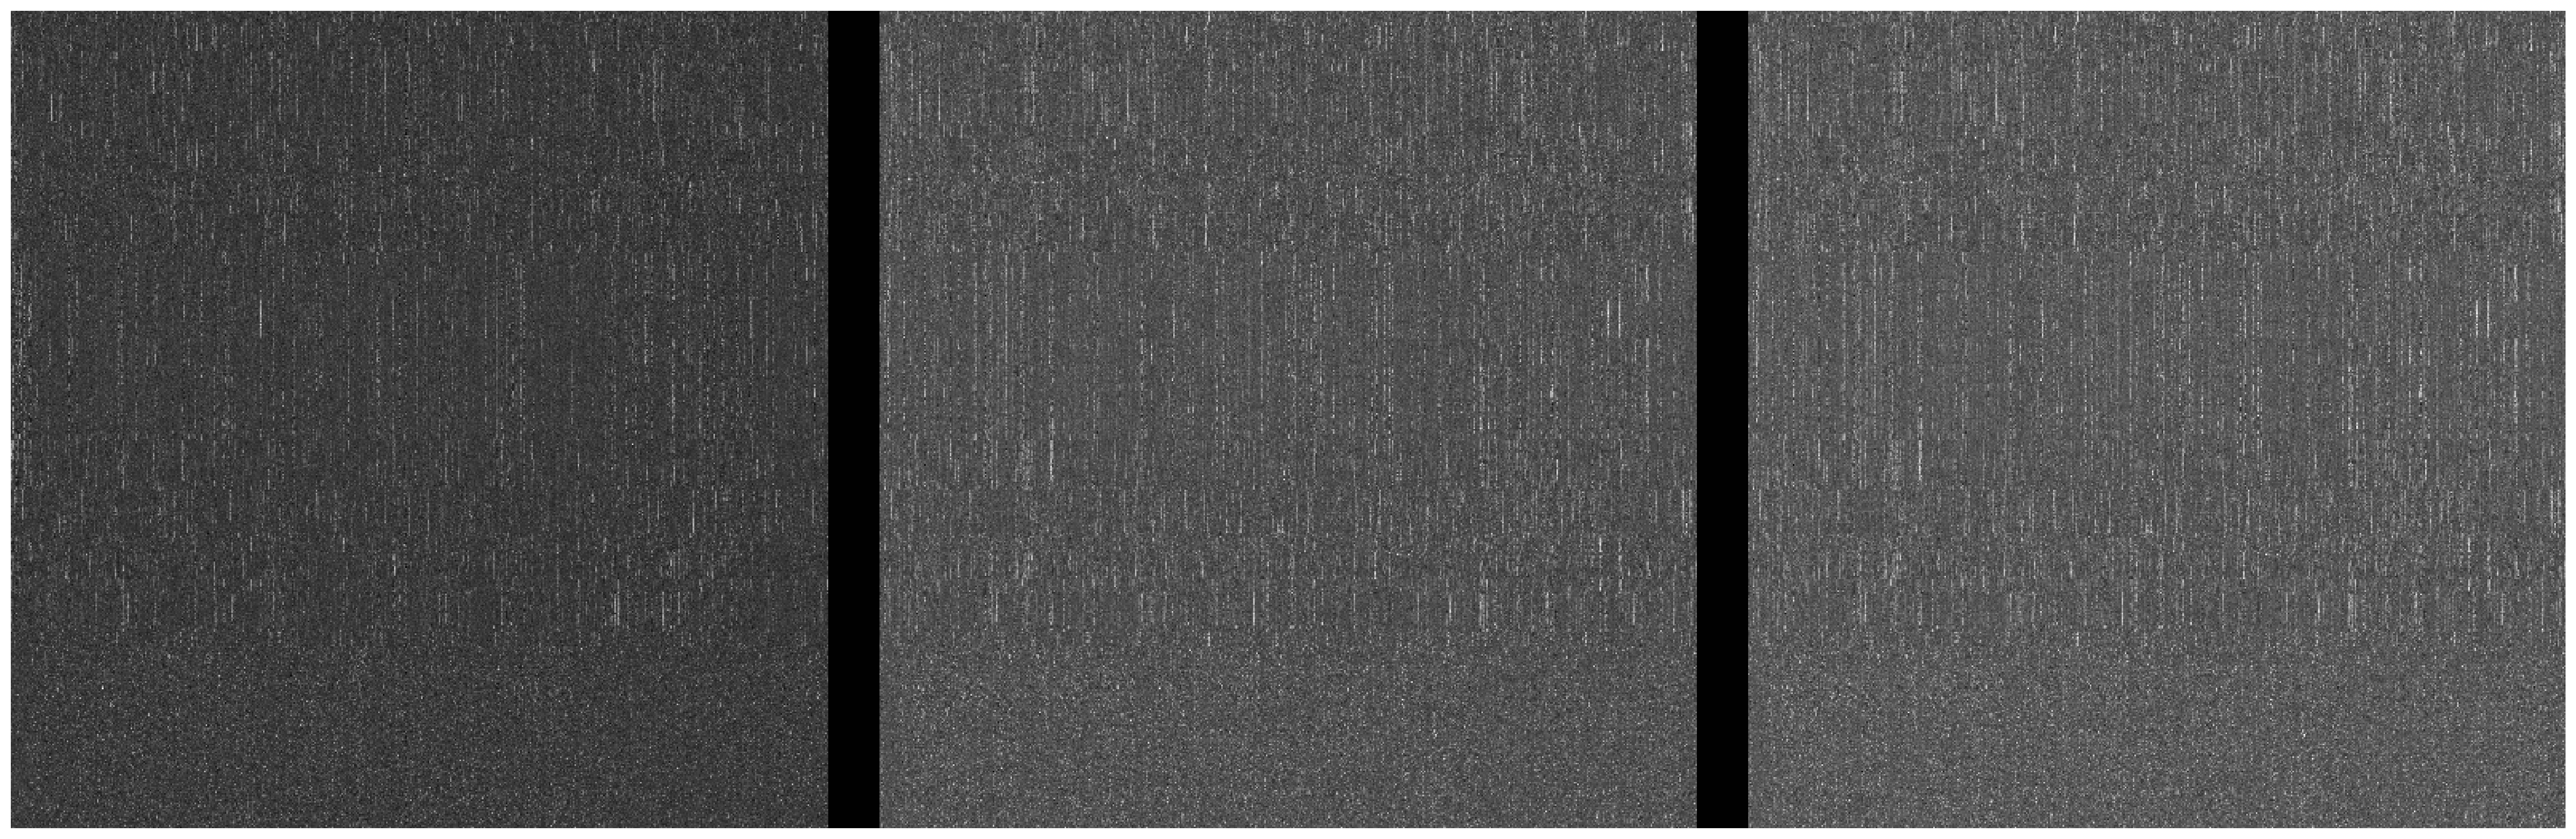

In [16]:
from __future__ import print_function
import sys
sys.path.append("..")
from util.util import lr_scheduler
from datasets.es_imagenet import ESImagenet_Dataset
import LIAF
from LIAFnet.LIAFResNet import *

import torchvision
import torchvision.transforms as transforms
import torch.distributed as dist 
import torch.nn as nn
import argparse, pickle, torch, time, os,sys
from importlib import import_module

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import matplotlib



##################### Step1. Env Preparation #####################
import os
save_folder = 'VizParam'
device = torch.device("cpu")

##################### Step2. load in dataset #####################

train_path = '/data/imagenet2012_png/train' 
test_path = '/data/imagenet2012_png/val' 

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 1
train_dataset = torchvision.datasets.ImageFolder(root= train_path, transform=transform_train)
test_dataset = torchvision.datasets.ImageFolder(root= test_path,transform=transform_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1,pin_memory=True)

##################### tep3. establish module #####################

checkpoint = torch.load('../exp_ES_imagenet/ResNet18_imagenet_CNN/65.pkl', map_location=torch.device('cpu'))
modules = import_module('LIAFnet.LIAFResNet_18')
CNN_config  = modules.Config()
CNN_config.cfgCnn = [3, 64, 7, True]
CNN = LIAFResNet(CNN_config)
CNN.load_state_dict(checkpoint)

checkpoint = torch.load('../exp_ES_imagenet/ResNet18_imagenet_LIAF/49.pkl', map_location=torch.device('cpu'))
LIF18_config  = modules.Config()
LIF18_config.cfgCnn = [3, 64, 7, True]
LIF18_config.actfun = LIAF.LIFactFun.apply
LIF18 = LIAFResNet(LIF18_config)
LIF18.load_state_dict(checkpoint)


checkpoint = torch.load('../exp_ES_imagenet/ResNet18_imagenet_LIAF/48.pkl', map_location=torch.device('cpu'))
LIAF18_config  = modules.Config()
LIAF18_config.cfgCnn = [3, 64, 7, True]
LIAF18 = LIAFResNet(LIF18_config)
LIAF18.load_state_dict(checkpoint)

    

CNNfc = CNN.fc
LIFfc = LIF18.fc
LIAFfc = LIAF18.fc

wieght_size = 0

for _,param in enumerate(CNNfc.named_parameters()):
    print(param[0])
    if param[0] == 'weight':
        wieght_size = 64

gap = int(wieght_size*8.5)
canve = torch.ones(wieght_size*8,wieght_size*8+gap*2,3)

for _,param in enumerate(CNNfc.named_parameters()):
    if param[0] == 'weight':
        a =  param[1]
        for i in range(64):
            canve[i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size,0] = param[1][i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size,1] = param[1][i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size,2] = param[1][i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size]
        
for _,param in enumerate(LIFfc.named_parameters()):
    if param[0] == 'weight':
        b =  param[1]
        for i in range(64):
            canve[i//8*wieght_size:(i//8+1)*wieght_size,gap+i%8*wieght_size:gap+(i%8+1)*wieght_size,1] = param[1][i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,gap+i%8*wieght_size:gap+(i%8+1)*wieght_size,2] = param[1][i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,gap+i%8*wieght_size:gap+(i%8+1)*wieght_size,0] = param[1][i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size]
        
for _,param in enumerate(LIAFfc.named_parameters()):
    if param[0] == 'weight':
        c =  param[1]
        for i in range(64):
            canve[i//8*wieght_size:(i//8+1)*wieght_size,2*gap+i%8*wieght_size:2*gap+(i%8+1)*wieght_size,1] = param[1][i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,2*gap+i%8*wieght_size:2*gap+(i%8+1)*wieght_size,2] = param[1][i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size]
            canve[i//8*wieght_size:(i//8+1)*wieght_size,2*gap+i%8*wieght_size:2*gap+(i%8+1)*wieght_size,0] = param[1][i//8*wieght_size:(i//8+1)*wieght_size,i%8*wieght_size:(i%8+1)*wieght_size]
        

def norm_canve(canve):
    return (canve - torch.min(canve))/(torch.max(canve)-torch.min(canve)) * 255

canve[:,0:wieght_size*8,:] =  norm_canve(canve[:,0:wieght_size*8,:])
canve[:,gap:gap+wieght_size*8,:] =  norm_canve(canve[:,gap:gap+wieght_size*8,:])
canve[:,gap*2:gap*2+wieght_size*8,:] =  norm_canve(canve[:,gap*2:gap*2+wieght_size*8,:])


task = 'param_imagenet_fc_'

plt.rcParams['figure.figsize'] = (32.5,10) # 设置figure_size尺寸
plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率


plt.figure("test") # 图像窗口名称
plt.imshow(canve.int().numpy())
plt.axis('off') # 关掉坐标轴为 off
plt.savefig('Visresult/'+task+'_IM.png', format='png')
plt.show()

#print(torch.sum(abs(c-a))/64)